# Analysis of `trips-info.xml`

In [26]:
import pprint
from lxml import etree
import matplotlib.pyplot as plt
import numpy as np

from paths import normal, scenarios

def get_trips(file_path):
    class SAXParser:
        def __init__(self):
            self.trips = []
            self.current_trip = {}

        def start(self, tag, attr):
            if tag == "tripinfo":
                self.current_trip["id"] = attr["id"]
                self.current_trip["duration"] = float(attr["duration"])
                self.current_trip["routeLength"] = float(attr["routeLength"])
                self.current_trip["rerouteNo"] = float(attr["rerouteNo"])

            if tag == "emissions":
                for key in attr:
                    self.current_trip[key] = float(attr[key])
                

        def end(self, tag):
            if tag == "tripinfo":
                self.trips.append(self.current_trip)
                self.current_trip = {}

        def close(self):
            pass

    sax_parser = SAXParser()
    xml_parser = etree.XMLParser(target=sax_parser)
    etree.parse(file_path, parser=xml_parser)

    return sax_parser.trips

metrics = {
    "distance": {
        "key": "routeLength",
        "scale": 1000,
        "unit": "km",
        "label": "Distance"
    },
    "duration": {
        "key": "duration",
        "scale": 60,
        "unit": "min",
        "label": "Duration"
    },
    "CO2": {
        "key": "CO2_abs",
        "unit": "mg",
        "label": "CO2"
    },
    "PMx": {
        "key": "PMx_abs",
        "unit": "mg",
        "label": "PMx"
    },
    "NOx": {
        "key": "NOx_abs",
        "unit": "mg",
        "label": "NOx"
    },
    "fuel": {
        "key": "fuel_abs",
        "unit": "ml",
        "label": "Fuel"
    },
}

# prefix n_ for normal
n_trips = get_trips(f"{normal}/trips-info.xml")
scenario_data = {}

for s in scenarios:
    trips = get_trips(f"{s}/trips-info.xml")
    scenario_data[s] = trips

### Mean value comparison for all vehicles

In [27]:
for s in scenarios:
    s_trips = scenario_data[s]

    for metric in metrics:
        key = metrics[metric]["key"]
        unit = metrics[metric]["unit"]

        n_values = np.array(list(map(lambda t: t[key], n_trips)))
        s_values = np.array(list(map(lambda t: t[key], s_trips)))

        if "scale" in metrics[metric]:
            scale = metrics[metric]["scale"]
            n_values = n_values / scale
            s_values = s_values / scale

        print(f"Mean {metric}")
        print(f"{normal}:", n_values.mean(), unit)
        print(f"{s}:", s_values.mean(), unit)
        print("Difference:", s_values.mean() - n_values.mean(), unit, "\n")

Mean distance
normal-output: 2.994053172526574 km
apats-output: 3.5280345625511043 km
Difference: 0.5339813900245303 km 

Mean duration
normal-output: 6.249727446170619 min
apats-output: 7.514690651403653 min
Difference: 1.264963205233034 min 

Mean CO2
normal-output: 827814.4838715635 mg
apats-output: 965152.0915145698 mg
Difference: 137337.60764300637 mg 

Mean PMx
normal-output: 15.024481753883896 mg
apats-output: 17.34798319705642 mg
Difference: 2.323501443172523 mg 

Mean NOx
normal-output: 339.85039089615697 mg
apats-output: 395.60139452085036 mg
Difference: 55.751003624693396 mg 

Mean fuel
normal-output: 355.8485758683565 ml
apats-output: 414.8853640735895 ml
Difference: 59.03678820523305 ml 



### Mean distance/duration comparison only for rerouted vehicles

In [35]:
for s in scenarios:
    s_trips = scenario_data[s]

    rr_s_trips = list(filter(lambda t: t["rerouteNo"] > 0, s_trips))
    rr_ids = list(map(lambda t: t["id"], rr_trips))
    rr_n_trips = list(filter(lambda t: t["id"] in rr_ids, n_trips))

    for metric in metrics:
        key = metrics[metric]["key"]
        unit = metrics[metric]["unit"]

        n_values = np.array(list(map(lambda t: t[key], rr_n_trips)))
        s_values = np.array(list(map(lambda t: t[key], rr_s_trips)))

        if "scale" in metrics[metric]:
            scale = metrics[metric]["scale"]
            n_values = n_values / scale
            s_values = s_values / scale

        print(f"Mean {metric}")
        print(f"{normal}:", n_values.mean(), unit)
        print(f"{s}:", s_values.mean(), unit)
        print("Difference:", s_values.mean() - n_values.mean(), unit, "\n")

Mean distance
normal-output: 3.7233370223325064 km
apats-output: 5.343833325062035 km
Difference: 1.6204963027295287 km 

Mean duration
normal-output: 7.570140612076097 min
apats-output: 11.395781637717121 min
Difference: 3.8256410256410245 min 

Mean CO2
normal-output: 1007672.8499770099 mg
apats-output: 1422722.5295524343 mg
Difference: 415049.6795754244 mg 

Mean PMx
normal-output: 18.25379782630273 mg
apats-output: 25.278649362282877 mg
Difference: 7.024851535980147 mg 

Mean NOx
normal-output: 412.8231462258065 mg
apats-output: 581.3397865707196 mg
Difference: 168.51664034491313 mg 

Mean fuel
normal-output: 433.1632271265509 ml
apats-output: 611.5790342977667 ml
Difference: 178.41580717121582 ml 



### Additional distance/duration for rerouted vehicles

Mean additional distance: 1.6204963027295287 km
Mean fractional increase: 0.4297989925407551 

Mean additional duration: 3.825641025641025 min
Mean fractional increase: 0.5468163735483431 

Mean additional CO2: 415049.67957542435 mg
Mean fractional increase: 0.439146842390519 

Mean additional PMx: 7.024851535980149 mg
Mean fractional increase: 0.44003342982180516 

Mean additional NOx: 168.51664034491316 mg
Mean fractional increase: 0.4433199263605262 

Mean additional fuel: 178.4158071712159 ml
Mean fractional increase: 0.43915065831827427 



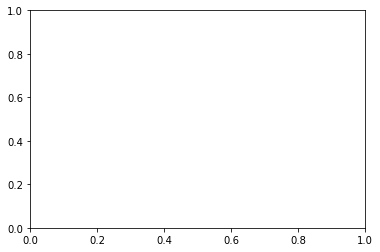

In [34]:
fig, ax = plt.subplots()

for s in scenarios:
    s_trips = scenario_data[s]

    rr_s_trips = list(filter(lambda t: t["rerouteNo"] > 0, s_trips))
    rr_ids = list(map(lambda t: t["id"], rr_trips))
    rr_n_trips = list(filter(lambda t: t["id"] in rr_ids, n_trips))

    for metric in metrics:
        key = metrics[metric]["key"]
        unit = metrics[metric]["unit"]

        additional_values = []
        additional_percent = []
        for rr_s_t in rr_s_trips:
            rr_n_t = list(filter(lambda t: t["id"] == rr_s_t["id"], rr_n_trips))[0]
            additional_values.append(rr_s_t[key] - rr_n_t[key])
            additional_percent.append((rr_s_t[key] - rr_n_t[key]) / rr_n_t[key])
        
        additional_values = np.array(additional_values)
        additional_percent = np.array(additional_percent)

        if "scale" in metrics[metric]:
            scale = metrics[metric]["scale"]
            additional_values = additional_values / scale

        print(f"Mean additional {metric}:", additional_values.mean(), unit)
        print(f"Mean fractional increase:", additional_percent.mean(), "\n")